In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import odeint
from matplotlib.animation import FuncAnimation
from scipy import stats

## Integrating functions

In [2]:
def derivative(X, t): #, N, A, B, K, J, alpha, beta, gamma, white_noise, sigma, Dx, Dy, Dtheta): # compute X_dot to use in the integration
    
    X_dot = np.zeros((N,4))
    
    if F != 0:
        forcing = F*np.cos(Omega*t - X[:, 2])/np.linalg.norm(center - X[:, :2], axis = 1) # size (N, )
    else:
        forcing = 0
        
    diff = X[:, np.newaxis, :3] - X[np.newaxis, :, :3] # size (N, N, 3) # each term of matrix NxN has x_i - x_j, y_i - y_j, theta_i - theta_j

    #equivalent to:
    #diff = np.zeros((N, N, 3))
    #for i in range(N):
    #    for j in range(N):
    #        diff[i, j, :3] = X[i, :3] - X[j, :3]
    
    #assert np.testing.assert_equal(diff - (X[:, np.newaxis, :3] - X[np.newaxis, :, :3]), np.zeros((N, N, 3)), "hello")
    
    
    distances = np.linalg.norm(diff[:, :, :2], axis=2) # size (N, N) # matrix of distances 
    np.fill_diagonal(distances, np.inf) # set distance from itself to infinity to force the interaction to 0
    
    A_ij = np.where(distances < r, 1, 0) # size (N, N)
    A_k_i = np.sum(A_ij, axis = 1).astype('float') # size (N, )
    B_k_i = N - A_k_i - 1 # size (N, )
    A_k_i[A_k_i == 0] = np.inf # to avoid dividing by zero on theta_dot_all
    B_k_i[B_k_i == 0] = np.inf # to avoid dividing by zero on theta_dot_all
    
    #K_ij = np.where(distances < r, K_a, K_r) # size (N, N) # symmetric
    K_ij = np.where(distances < r, K_a / A_k_i[:, np.newaxis], K_r / B_k_i[:, np.newaxis]).T
    
    phase_diff = diff[:, :, 2] # size (N, N) # matrix of phase differences
    phase_similarity = A + J*np.cos(phase_diff) # F of the paper # size (N, N)
    phase_attraction = K_ij*np.sin(phase_diff) # H_att of the paper # size (N, N)
    
    #add velocity term
    cos_beta = np.cos(X[:, 3])
    sin_beta = np.sin(X[:, 3])
    n_hat = np.column_stack((cos_beta, sin_beta)) #size (N, 2)
    
    #calculate beta dot
    if ALIGNMENT:
        D_ij = np.where(distances < delta, 1, 0) # size (N, N)
        D_k_i = np.sum(D_ij, axis = 1).astype('float') # size (N, )
        D_k_i[D_k_i == 0] = np.inf # to avoid dividing by zero on beta_dot
        beta_dot = (- X[:, 3] + np.sum(D_ij*X[:, 3]/D_k_i, axis = 1).astype('float')).reshape(N, 1) # size (N, 1)
    else:
        beta_dot = np.zeros((N,1))
        
    x_dot_all = ((diff[:, :, :2].T*(phase_similarity/distances**alpha - B/distances**beta)).T)/N # size (N, N, 2)
    theta_dot_all = ((phase_attraction/distances**gamma) + 0*forcing).reshape(N, N, 1) # size (N, N, 1)
    X_dot_all = np.concatenate([x_dot_all, theta_dot_all], axis = 2) # size (N, N, 3)
    
    X_dot = np.sum(X_dot_all, axis = 0) # sum over j, size (N, 3)
    X_dot[:, 2] += omega + forcing
    #omega from cauchy distribution
    #cauchy distribution: location-scale family
    #if you draw a sample x from Cauchy(0, 1), just shift it by x_0 and multiply with gamma and
    #x' = x_0 + gamma * x will be distributed according to Cauchy(x_0, gamma)
    
    X_dot[:, :2] += v0 * n_hat
    X_dot = np.concatenate([X_dot, beta_dot], axis = 1)
    
    return X_dot

In [3]:
def generate_noise(Dx, Dy, Dtheta, Dbeta, dt):
    
    #add noise term
    noise = np.zeros((N,4))
    noise[:, :2] = np.random.normal(scale=[np.sqrt(2*Dx*dt), np.sqrt(2*Dy*dt)], size=(N, 2))
    noise[:, 2] = np.random.normal(scale=np.sqrt(2*Dtheta*dt), size=N)
    noise[:, 3] = np.random.normal(scale=np.sqrt(2*Dbeta*dt), size=N)
    
    return noise

In [4]:
def generate_data_rk4(X0, dt = 0.1, n_iter = 1000): # runge kutta 4th order
     
    history_X = [X0]
    
    for t in tqdm(range(1, n_iter)):
        x = history_X[-1]
        k1 = derivative(x, t*dt)*dt
        k2 = derivative(x+k1/2, t*dt)*dt
        k3 = derivative(x+k2/2, t*dt)*dt
        k4 = derivative(x+k3, t*dt)*dt
        history_X.append(x + (k1+2*k2+2*k3+k4)/6)
    
    return history_X

In [5]:
def generate_data_rk2(X0, dt = 0.1, n_iter = 1000): # runge kutta 2nd order
    
    history_X = [X0]
    
    for t in tqdm(range(1, n_iter)):
        x = history_X[-1]
        k1 = derivative(x, t*dt)*dt
        k2 = derivative(x+k1, t*dt)*dt
        history_X.append(x + (k1+k2)/2)
    
    return history_X

In [6]:
def generate_data_rk2_noise(X0, dt = 0.1, n_iter = 1000): # runge kutta 2nd order with noise

    history_X = [X0]
    
    for t in tqdm(range(1, n_iter)):
        x = history_X[-1]
        k1 = derivative(x, t*dt)
        k2 = derivative(x + dt*k1 + generate_noise(Dx, Dy, Dtheta, Dbeta, dt), t*dt)
        history_X.append(x + (k1+k2)*dt/2 + generate_noise(Dx, Dy, Dtheta, Dbeta, dt))
    
    return history_X

In [7]:
def angle_transf(v_theta): # theta rescaling to [-pi, pi]
    v_theta = v_theta%(2*np.pi)
    out = np.where(v_theta > np.pi, v_theta - 2*np.pi, v_theta)
    return out

In [8]:
def plot_swarm(X, title): # plot system configuration at a given time
    plt.figure(figsize = (10, 8))
    
    colors = angle_transf(X[:, 2]) # Color based on phase (theta)
    
    scatter = plt.scatter(X[:, 0], X[:, 1], c = colors, cmap = 'rainbow', vmin = -np.pi, vmax = np.pi)
    plt.xlabel(r"$x$", fontsize = 15)
    plt.ylabel(r"$y$", fontsize = 15)
    plt.title(title, fontsize = 20)
    
    if ALIGNMENT:
        
        arrow_length = 0.2  # Length of the arrow
        for x, y, beta, color in zip(X[:, 0], X[:, 1], X[:, 3], colors):
            dx = arrow_length * np.cos(beta)
            dy = arrow_length * np.sin(beta)
            plt.arrow(x, y, dx, dy, color=scatter.to_rgba(color), alpha=0.8)
    
    else:
        
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        
        
    plt.colorbar().set_label(label = r"$\theta\ mod(2\pi)$",size=15)
    plt.show()

In [9]:
def animate(t, title): # animate swarmalators' dynamic
    
    ax.clear()
    
    x = trial[t, :, 0]
    y = trial[t, :, 1]
    theta = trial[t, :, 2]
    beta = trial[t, :, 3]
    colors = angle_transf(theta)
    scatter = ax.scatter(x, y, c = colors, cmap = 'rainbow', vmin = -np.pi, vmax = np.pi)
    
    if ALIGNMENT:
        
        arrow_length = 0.2
        dx = arrow_length*np.cos(beta)
        dy = arrow_length*np.sin(beta)
        ax.quiver(x, y, dx, dy, color=scatter.to_rgba(colors), alpha=0.8)
    
    else:
        # maybe also with alignment wee could want axes fixed
        ax.set_xlim(-2,2)
        ax.set_ylim(-2,2)
        
    ax.set_xlabel(r"$x$", fontsize = 15)
    ax.set_ylabel(r"$y$", fontsize = 15)
    ax.set_title(title, fontsize = 20)

## Simulation

In [89]:
seed = 42
np.random.seed(seed)

### model parameters
N = 1000
A = 1
B = 1

J = 1
r = 1000000 # very high number to not have an interaction range
K_a = -0.75 # the old K
K_r = 0 # set to 0 if only attractive

### forcing
F = 5
Omega = 3*np.pi/2
center = np.array([0, 0])

### alignment + noise
ALIGNMENT = False
if ALIGNMENT:
    v0 = 0.001
else:
    v0 = 0
    
white_noise = True
sigma = 0.01
Dx = 0
Dy = 0
Dtheta = 0
Dbeta = 0
delta = 0.5


flag = 'const' # deprecated: Use only alpha = 1

if flag == 'const':
    alpha = 1
else:
    alpha = 0
    
beta = 2
gamma = 1

### folders and titles, change parameters if needed, for different parameters
folder_npy = "np arrays/forced/" #"np arrays/alignment/"
folder_video = "video/forced/" #"video/alignment/"
name_phase = "splintered phase wave forced F = 1" #change title if needed
name_video = folder_video + name_phase + ".mp4"
name_video_angle = folder_video + name_phase + "angle.mp4"

### integration variables
dt = 0.1
n_iter = 1000

### load data/save animation
LOAD = False
SAVE_NP = True
SAVE_VIDEO = False

(1000, 4)


In [ ]:
### initial conditions
x0 = np.random.uniform(-2, 2, size = (N, 2))
theta0 = np.random.uniform(-np.pi, np.pi, size = (N, 1))
if ALIGNMENT:
    omega = stats.cauchy.rvs(scale = sigma, size=N) #sigma*np.random.standard_cauchy(size=N)
    beta0 = np.random.uniform(-np.pi, np.pi, size = (N, 1))
else:
    omega = np.zeros(N) #sigma*np.random.standard_cauchy(size=N)
    beta0 = np.zeros((N, 1))

X0 = np.concatenate([x0, theta0, beta0], axis = 1)
print(X0.shape)

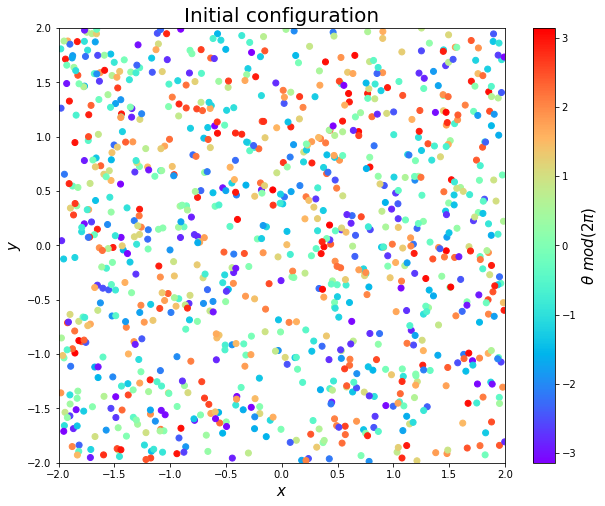

In [90]:
plot_swarm(X0, title = "Initial configuration")

In [91]:
if not LOAD: 
    trial = generate_data_rk2_noise(X0, dt = dt, n_iter = n_iter)
    trial = np.stack(trial)
    if SAVE_NP:
        np.save(folder_npy+"J={}_K={}_F={}_N={}_".format(J, K_a, F, N)+".npy", trial)
        ### CHANGE NAME TO THE NPY ARRAYS, this is the case associated to the forcing term
        #trial = np.load(folder_npy+"J={}_K={}_N={}_Db={}_dt={}_".format(J, K, N, Dbeta, dt)+flag+"_aligned.npy")

100%|██████████| 999/999 [04:39<00:00,  3.57it/s]


## Animation

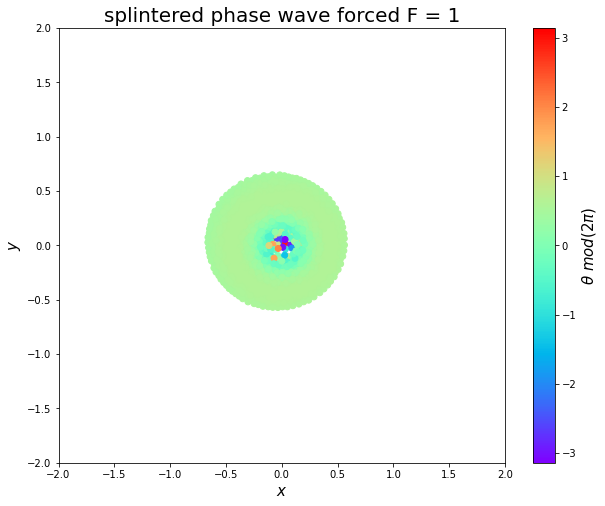

In [92]:
if LOAD:
    trial = np.load(folder_npy+"J={}_K={}_F={}_N={}_".format(J, K_a, F, N)+".npy") # +flag
    ### CHANGE NAME TO THE NPY ARRAYS, this is the case associated to the forcing term
    #trial = np.load(folder_npy+"J={}_K={}_N={}_Db={}_dt={}_".format(J, K, N, Dbeta, dt)+flag+"_aligned.npy")
    
t = (n_iter-1)//1

plot_swarm(trial[t], title = name_phase)

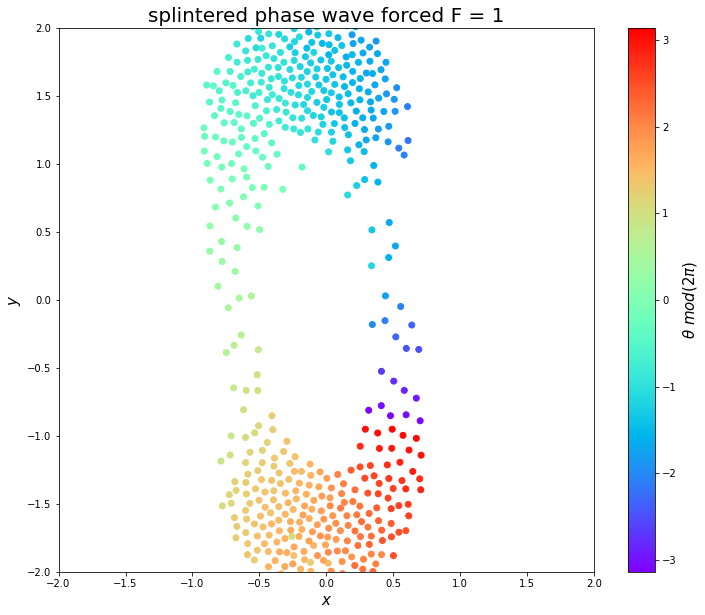

In [26]:
fig, ax = plt.subplots(figsize = (12,10))

scatter = ax.scatter(trial[0, :, 0], trial[0, :, 1], c = angle_transf(trial[0, :, 2]), cmap = 'rainbow', vmin = -np.pi, vmax = np.pi)

if ALIGNMENT:
    arrow_length = 0.2
    dx = arrow_length*np.cos(trial[0, :, 3])
    dy = arrow_length*np.sin(trial[0, :, 3])
    ax.quiver(trial[0, :, 0], trial[0, :, 1], dx, dy, color=scatter.to_rgba(angle_transf(trial[0, :, 2])), alpha=0.8)

cbar = plt.colorbar(scatter)
cbar.set_label(label = r"$\theta\ mod(2\pi)$", size=15)

animation = FuncAnimation(fig, animate, frames=n_iter, interval=100, fargs = (name_phase,))

if SAVE_VIDEO:
    animation.save(filename=name_video, fps=60)
    
plt.show()

## Plots

In [93]:
def plot_angles(X_sph, title):
    plt.figure(figsize = (8, 8))
    plt.scatter(X_sph[:, 1], X_sph[:, 2]%(2*np.pi))
    plt.xlabel(r'$\varphi$', fontsize = 15)
    plt.ylabel(r'$\theta$', fontsize = 15)
    plt.title(title, fontsize = 20)
    plt.xlim(0,2*np.pi)
    plt.ylim(0,2*np.pi)

In [94]:
trial_sph = np.zeros_like(trial)
trial_sph[:, :, 0] = np.linalg.norm(trial[:, :, :2], axis = 2)
trial_sph[:, :, 1] = (np.arctan2(trial[:, :, 1], trial[:, :, 0]) + (2*np.pi))%(2*np.pi)
trial_sph[:, :, 2] = trial[:, :, 2]

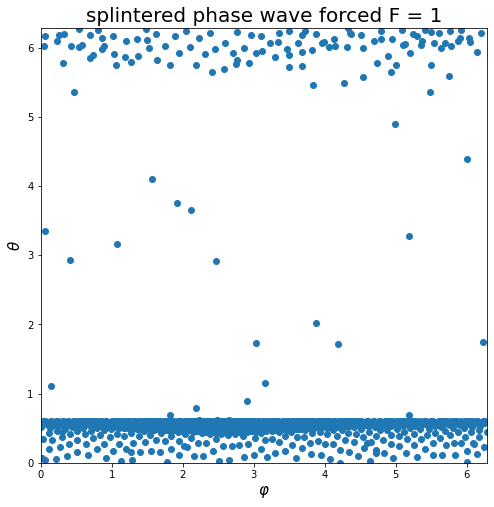

In [95]:
plot_angles(trial_sph[-1], title = name_phase)

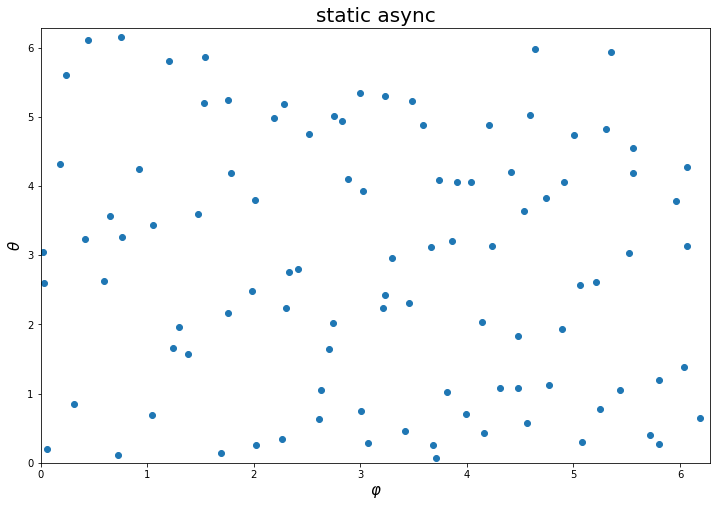

In [31]:
def animate_angles(t, title):
    ax.clear()
    #im = ax.scatter(trial[t, :, 0], trial[t, :, 1], c = trial[t, :, 2]%(2*np.pi)-np.pi, cmap = 'rainbow')
    ax.scatter(trial_sph[t, :, 1], trial_sph[t, :, 2]%(2*np.pi))
    #fig.colorbar(im, orientation='vertical')
    ax.set_xlabel(r'$\varphi$', fontsize = 15)
    ax.set_ylabel(r'$\theta$', fontsize = 15)
    ax.set_title(title, fontsize = 20)
    ax.set_xlim(0,2*np.pi)
    ax.set_ylim(0,2*np.pi)

fig, ax = plt.subplots(figsize = (12,8))
animation_angle = FuncAnimation(fig, animate_angles, frames=1000, interval=100, fargs = (name_phase,))
animation_angle.save(filename='video/videoacaso.mp4',fps=60)
plt.show()